# Summarizing jobs' descriptions to titles

## About
The encoder-decoder architecture from BART models have proven to be extremely useful for text-summarization tasks. In this notebook I attempt to summarize [LinkedIn jobs posts](https://www.kaggle.com/datasets/arshkon/linkedin-job-postings) descriptions to its original titles using the BART-Base checkpoint.

## Imports

In [4]:
# !pip install datasets evaluate rouge_score transformers transformers[torch]

In [5]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", 
              style="white")

from datasets import Dataset
import evaluate
from transformers import (BartTokenizer,
                          BartForConditionalGeneration,
                          DataCollatorForSeq2Seq,
                          EarlyStoppingCallback,
                          Seq2SeqTrainingArguments,
                          Seq2SeqTrainer)
import torch

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
# Path to data
path = "/kaggle/input/linkedin-job-postings/job_postings.csv"

# Read the data
df = pd.read_csv(path)
df.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
0,85008768,NaN,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,USD,BASE_SALARY
1,133114754,77766802.0,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,FULL_TIME,NaN,NaN
2,133196985,1089558.0,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...,NaN,NaN,NaN,NaN,Contract,"New York, NY",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,CONTRACT,NaN,NaN
3,381055942,96654609.0,Business Manager,Business ManagerFirst Baptist Church ForneyFor...,NaN,NaN,NaN,NaN,Full-time,"Forney, TX",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,FULL_TIME,NaN,NaN
4,529257371,1244539.0,NY Studio Assistant,YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...,NaN,NaN,NaN,NaN,Full-time,"New York, NY",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,NaN,NaN


In [8]:
# Remove unused columns
df = df[["title", "description"]].copy(deep=True)
df.head()

,title,description
0,Licensed Insurance Agent,While many industries were hurt by the last fe...
1,Sales Manager,Are you a dynamic and creative marketing profe...
2,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...
3,Business Manager,Business ManagerFirst Baptist Church ForneyFor...
4,NY Studio Assistant,YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...


## Basic EDA

In [9]:
df.shape

(15886, 2)

In [10]:
# NaNs count
df.isnull().sum()

title          0
description    1
dtype: int64

In [11]:
# Check where the NaNs are
df.loc[(df["title"].isnull()) | (df["description"].isnull())]

,title,description
6252,Senior Universal Banker,NaN


In [12]:
# Drop NaNs
df.dropna(inplace=True)

In [13]:
sample_data = df.sample(n=3, random_state=123)
for _, sample in sample_data.iterrows():
    print(sample["title"], "\n")
    print(sample["description"])
    print("---------------------", "\n")

National Purchasing Analyst 

Overview
 BREAK GROUND ON A REWARDING CAREER WITH US! 
At MDC Holdings, Inc. /Richmond American Homes, we encourage a company culture that promotes professionalism, teamwork, health & wellness and work-life balance. If you are a results-driven professional with a passion for success, consider building a career with us. We’re proud to be one of the most established builders in the industry, with 45 years of experience and 240,000 homes to our credit.
Position Summary
We are currently seeking a qualified National Purchasing Analyst to join our team. The Purchasing Analyst will play a key role in the company’s Purchasing functions and assist to collaboratively implement sourcing strategies that deliver best total value for Richmond American Homes Divisions for assigned markets and trade categories. This position will contribute to the success of the Procurement/Purchasing Organization through a comprehensive understanding of home building, purchasing, product

In [14]:
# Length of descriptions and titles
def get_word_count(text):
    return len(text.split())

# Char length
df["description_len"] = df["description"].str.len()
df["title_len"] = df["title"].str.len()

# Word length
df["description_n_words"] = df["description"].apply(lambda x: get_word_count(x))
df["title_n_words"] = df["title"].apply(lambda x: get_word_count(x))

df.head()

,title,description,description_len,title_len,description_n_words,title_n_words
0,Licensed Insurance Agent,While many industries were hurt by the last fe...,1825,24,276,3
1,Sales Manager,Are you a dynamic and creative marketing profe...,2729,13,369,2
2,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...,1960,18,263,3
3,Business Manager,Business ManagerFirst Baptist Church ForneyFor...,2160,16,298,2
4,NY Studio Assistant,YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...,1919,19,272,3


### Make some cool plots

#### Character count

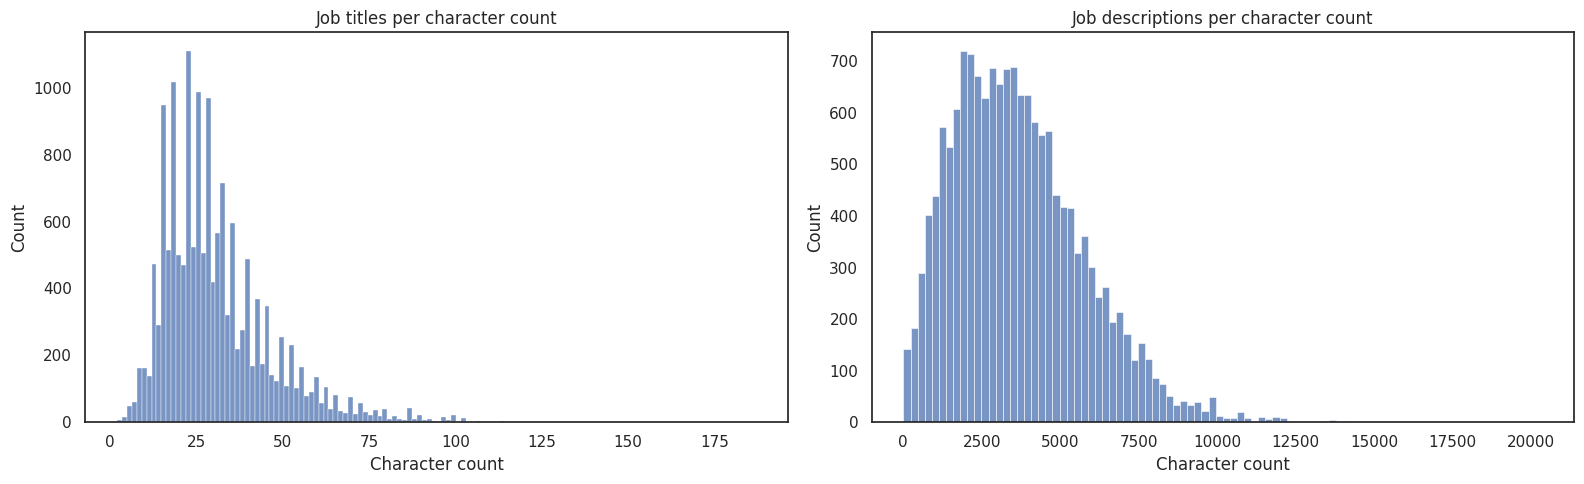

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Title - aka 'labels'
sns.histplot(data=df, x="title_len", ax=axes[0])
axes[0].set_title("Job titles per character count")
axes[0].set_xlabel("Character count")

# Description - aka 'features'
sns.histplot(data=df, x="description_len", ax=axes[1])
axes[1].set_title("Job descriptions per character count")
axes[1].set_xlabel("Character count")

fig.tight_layout()
plt.show()

#### Word count

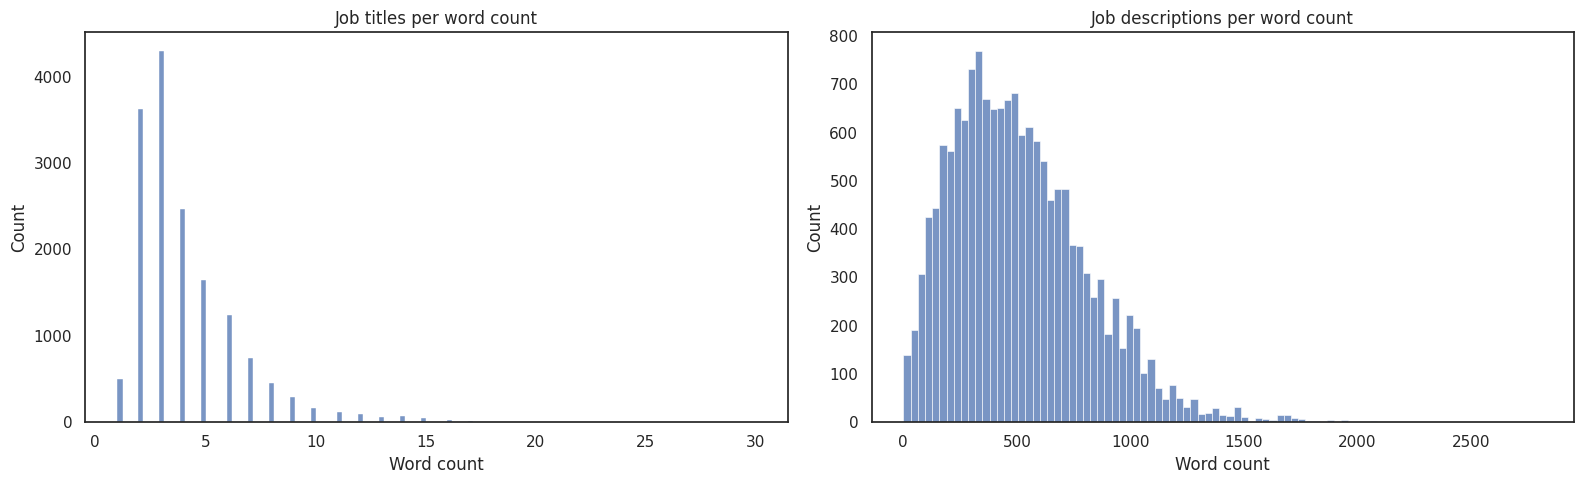

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Title - aka 'labels'
sns.histplot(data=df, x="title_n_words", ax=axes[0])
axes[0].set_title("Job titles per word count")
axes[0].set_xlabel("Word count")

# Description - aka 'features'
sns.histplot(data=df, x="description_n_words", ax=axes[1])
axes[1].set_title("Job descriptions per word count")
axes[1].set_xlabel("Word count")

fig.tight_layout()
plt.show()

#### Correlation between length of titles and discriptions

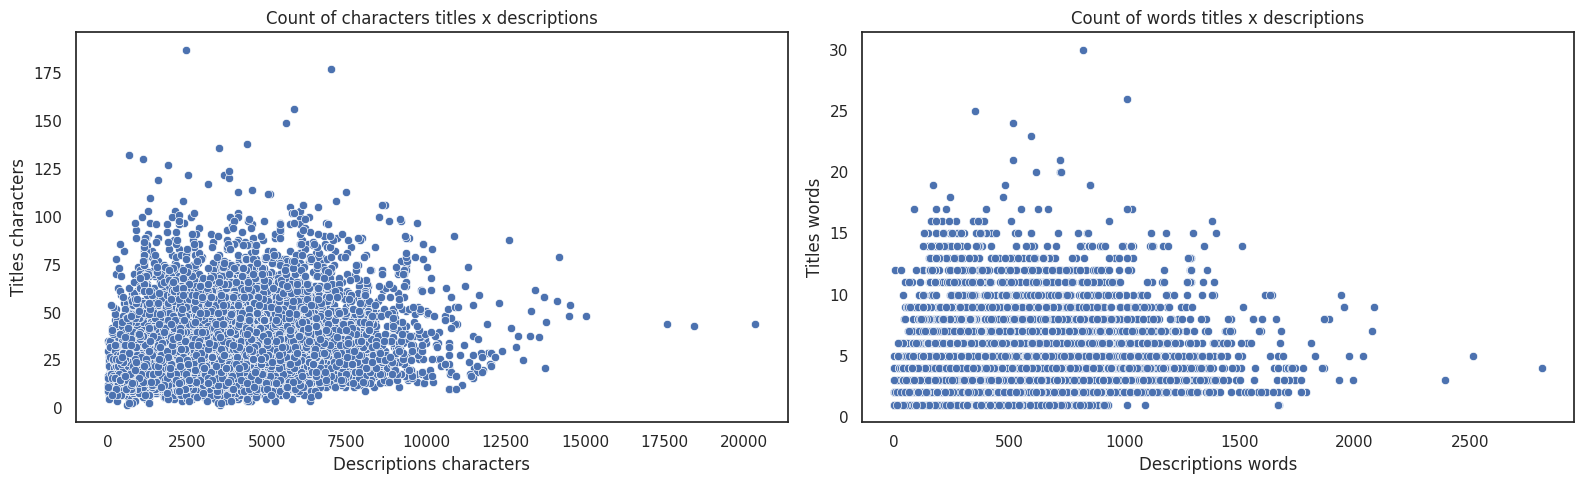

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Character count
sns.scatterplot(data=df, y="title_len", x="description_len", ax=axes[0])
axes[0].set_title("Count of characters titles x descriptions")
axes[0].set_xlabel("Descriptions characters")
axes[0].set_ylabel("Titles characters")

# Word count
sns.scatterplot(data=df, y="title_n_words", x="description_n_words", ax=axes[1])
axes[1].set_title("Count of words titles x descriptions")
axes[1].set_xlabel("Descriptions words")
axes[1].set_ylabel("Titles words")

fig.tight_layout()
plt.show()

In [18]:
df[["title_len", "description_len"]].corr()

,title_len,description_len
title_len,1.000000,0.209552
description_len,0.209552,1.000000


In [19]:
df[["title_n_words", "description_n_words"]].corr()

,title_n_words,description_n_words
title_n_words,1.000000,0.180751
description_n_words,0.180751,1.000000


#### Takeouts from basic EDA

It seems there's no strong correlation between the titles' and descriptions' sizes for both characters and words.

## Modeling using BART

In [20]:
# Tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# Model
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

In [21]:
# Sample only 2000 instances so Kaggle won't crash
df = df.sample(n=2_000, random_state=123).copy(deep=True)

# Split into train/validation
train_df, val_df = train_test_split(df[["title", "description"]],
                                    test_size=.1,
                                    random_state=123)
print(f"Train DataFrame size: {train_df.shape}")
print(f"Val DataFrame size: {val_df.shape}")

Train DataFrame size: (1800, 2)
Val DataFrame size: (200, 2)


In [22]:
train_set = Dataset.from_pandas(train_df,
                                preserve_index=False)

val_set = Dataset.from_pandas(val_df,
                              preserve_index=False)

In [23]:
train_set

Dataset({
    features: ['title', 'description'],
    num_rows: 1800
})

In [24]:
def tokenize_func(sample):
    global tokenizer
    tokenized_sample = tokenizer(sample["description"],
                               truncation=True)
    tokenized_label = tokenizer(sample["title"],
                              truncation=True)
    tokenized_sample.update({"labels": tokenized_label["input_ids"]})
    return tokenized_sample

train_set_tokenized = train_set.map(tokenize_func, batched=True, remove_columns=["title", "description"])
val_set_tokenized = val_set.map(tokenize_func, batched=True, remove_columns=["title", "description"])

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [25]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    global tokenizer, rouge
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [26]:
data_collator = DataCollatorForSeq2Seq(tokenizer, 
                                       padding=True,
                                       max_length=256,
                                       pad_to_multiple_of=8)

In [27]:
# Estimating train steps per epoch and total train steps
batch_size = 4
epochs = 10
grad_acc = 40
training_steps_per_epoch = int(np.ceil(len(train_set) / (batch_size * grad_acc))) - 1
training_steps = epochs * training_steps_per_epoch
print(f"Train steps: {training_steps}")
print(f"Steps per epoch: {training_steps_per_epoch}")
print(f"Train virtual batch_size: {batch_size * grad_acc}")

Train steps: 110
Steps per epoch: 11
Train virtual batch_size: 160


In [28]:
torch.cuda.empty_cache()

In [29]:
train_args = Seq2SeqTrainingArguments(
    output_dir="bart-jobs-summarizer",
    seed=123,
    learning_rate=1e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=1e-2,
    num_train_epochs=10,
    fp16=True,
    gradient_accumulation_steps=40,

    # Saving
    save_strategy="steps", # To use callbacks
    save_steps=10, # save_steps/eval_acc_steps - Save every 10/5 = 2 evaluations
    push_to_hub=False,

    # Callbacks
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True, 

    # Eval
    do_eval=True,
    evaluation_strategy="steps",
    logging_strategy="steps",
    logging_steps=5,
    eval_accumulation_steps=5, # Reduces memory consumptio during eval
    
    report_to="none", # Turn off WandB
)

early_stop_callback = EarlyStoppingCallback(3, 0.005)

trainer = Seq2SeqTrainer(model=model,
                         args=train_args,
                         train_dataset=train_set_tokenized,
                         eval_dataset=val_set_tokenized, 
                         tokenizer=tokenizer, 
                         data_collator=data_collator, 
                         callbacks=[early_stop_callback], 
                         compute_metrics=compute_metrics)

In [ ]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Step,Training Loss,Validation Loss
